<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import re
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from string import digits

import math
import pickle

from collections import Counter

In [4]:
# %cd 'drive/MyDrive/signal classifier models/lstm'
%cd 'drive/MyDrive/crypto-classifier/data'
!ls
with open ('tag3/cleanTweet1000.pickle', 'rb') as fp:
    dataset = pickle.load(fp)

/content/drive/MyDrive/crypto-classifier/data
 120_influ_total.json			    lunarcrush_influencers
 2000_crypto_sample.csv			    model.pt
 20coin_MC_lunarCrush_30days.csv	    models
 20coin_MC_lunarCrush_60days.csv	    multy_platform
 all_tweets.v2.csv			    new_sell.csv
 cardiffnlp				    new_tag
'classification_reports (1).gsheet'	    old
 classification_reports.csv		    parameter_tuning.csv
 classification_reports.gsheet		    parameter_tuning.gsheet
 cleaned_dataset.csv			    predict_crypto_keyword_2000.csv
 cleaned_dataset.pickle			    predict_crypto_keyword_2000.xlsx
 cleaned_dataset_sell.pickle		    reddit_data.csv
 cleanTweet_800.csv			    relevant_crypto_TfidfVectorizer
 coinList_100.csv			    Relevant_model
 coin_name.csv				    result_data.zip
 crypto_augmented_features_relevant	    sample_instagram_3000.v1.csv
 crypto_augmented_features_signal	    sample_reddit_3000.v1.csv
 crypto_keyword_total.csv		    stop_words_english.txt
 crypto_signal_model			    tag3
 data_with_sell_key

# code

In [5]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
dataset.columns
dataset['signal']=dataset['signal'].apply(lambda x:'not buy' if x in ['sell','no signal','hold'] else x)
print('signal categories: ',Counter(dataset['signal']))

X = dataset['unicode_text_concat'].to_list()
y = dataset['signal'].to_list()

labels = {'not buy':0, 'buy':1}
for i in range(len(y)):
  dataset['signal'][i]=labels[dataset['signal'][i]]

signal categories:  Counter({'buy': 1089, 'not buy': 838})


<ipython-input-6-7850e67f7d8a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['signal'][i]=labels[dataset['signal'][i]]


In [7]:
sentences = dataset.iloc[:, dataset.columns.get_loc('clean_text')].values
labels = dataset.iloc[:,dataset.columns.get_loc('signal')].values

sentences=sentences.astype(str)
labels=labels.astype('int')

labels

array([1, 1, 1, ..., 1, 1, 0])

# preprocess

In [8]:
import nltk
nltk.download('punkt') # one time execution
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from nltk.tokenize import word_tokenize
import re

def clean_non_english(txt):
    txt = re.sub(r'\W+', ' ', txt)
    txt = txt.lower()
    txt = txt.replace("[^a-zA-Z]", " ")
    word_tokens = word_tokenize(txt)
    filtered_word = [w for w in word_tokens if all(ord(c) < 128 for c in w)]
    filtered_word = [w + " " for w in filtered_word]
    return "".join(filtered_word)


def split_numbers_with_space(string):
    return re.sub(r'(\d+)', r' \1 ', string)

def replace_numbers_with_placeholder(string):
    string_with_space = split_numbers_with_space(string)
    return re.sub(r'\d+', 'a_number', string_with_space)


def clean_text(english_txt):

    # lower case text
    english_txt=english_txt.lower()

    # initializing punctuations string
    punc = '''!()-[]{};:'"\,<>./?%^&*_~'''

    # Removing punctuations in string
    english_txt.translate(str.maketrans('', '', punc))

    english_txt = replace_numbers_with_placeholder(english_txt)

    word_tokens = english_txt.split()
    filtered_word = [w for w in word_tokens if not w in stop_words]
    filtered_word = [w + " " for w in filtered_word]
    return "".join(filtered_word)

In [10]:
dataset['clean_text']=dataset['clean_text'].apply(clean_text)

In [11]:
dataset[['clean_text']]

,clean_text
0,core philosophy revolve build ship product fin...
1,today's bitcoin upsurge coincide bitfinex main...
2,bitcoin world wbd a_number - colombia bitcoin ...
3,high leverage crypto market crash #bitcoin $ a...
4,feed print unlimited money pump market = good ...
...,...
1922,simon dixon mauricio bartlolomeo - swan signal...
1923,ukraine ukrainian government raise $ a_number ...
1924,number address hold a_number #bitcoin a_number...
1925,condition 'ripe' bitcoin adoption amid geopoli...


In [12]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [13]:
from sklearn.model_selection import train_test_split
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(sentences, labels, test_size = 0.20, random_state = 1)
training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(training_sentences, training_labels, test_size = 0.2, random_state = 1)


In [14]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [15]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [16]:
import matplotlib.pyplot as plt


def plot_graphs(history, string,file_name):

    plt.plot(list(map(str, list(range(1, len(history.history[string])+1)))),history.history[string])
    plt.plot(list(map(str, list(range(1, len(history.history[string])+1)))),history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.savefig(f'Figures/{file_name}.png', dpi=1080)
    plt.show()


Multiple Layer LSTM

In [175]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [176]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, None, 16)          160000    
                                                                 
 bidirectional_20 (Bidirect  (None, None, 128)         41472     
 ional)                                                          
                                                                 
 bidirectional_21 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dense_62 (Dense)            (None, 64)                4160      
                                                                 
 dense_63 (Dense)            (None, 1)                 65        
                                                                 
Total params: 246913 (964.50 KB)
Trainable params: 24

In [177]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [178]:
NUM_EPOCHS = 20
history = model.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(validation_padded, validation_labels), verbose=2)

Epoch 1/20
39/39 - 20s - loss: 0.6877 - accuracy: 0.5674 - val_loss: 0.6782 - val_accuracy: 0.5922 - 20s/epoch - 515ms/step
Epoch 2/20
39/39 - 4s - loss: 0.6710 - accuracy: 0.5836 - val_loss: 0.6562 - val_accuracy: 0.6019 - 4s/epoch - 114ms/step
Epoch 3/20
39/39 - 5s - loss: 0.3831 - accuracy: 0.8523 - val_loss: 0.7447 - val_accuracy: 0.6311 - 5s/epoch - 135ms/step
Epoch 4/20
39/39 - 3s - loss: 0.1682 - accuracy: 0.9448 - val_loss: 1.0623 - val_accuracy: 0.6084 - 3s/epoch - 69ms/step
Epoch 5/20
39/39 - 2s - loss: 0.0984 - accuracy: 0.9667 - val_loss: 1.0342 - val_accuracy: 0.6246 - 2s/epoch - 45ms/step
Epoch 6/20
39/39 - 2s - loss: 0.0809 - accuracy: 0.9716 - val_loss: 1.0331 - val_accuracy: 0.6602 - 2s/epoch - 60ms/step
Epoch 7/20
39/39 - 3s - loss: 0.0645 - accuracy: 0.9789 - val_loss: 1.0540 - val_accuracy: 0.6052 - 3s/epoch - 72ms/step
Epoch 8/20
39/39 - 2s - loss: 0.0710 - accuracy: 0.9756 - val_loss: 1.1757 - val_accuracy: 0.6343 - 2s/epoch - 49ms/step
Epoch 9/20
39/39 - 1s - los

13/13 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

           0       0.61      0.54      0.58       179
           1       0.64      0.71      0.67       207

    accuracy                           0.63       386
   macro avg       0.63      0.62      0.62       386
weighted avg       0.63      0.63      0.63       386



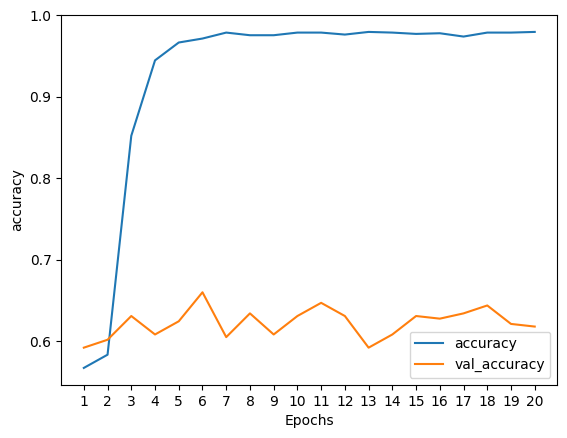

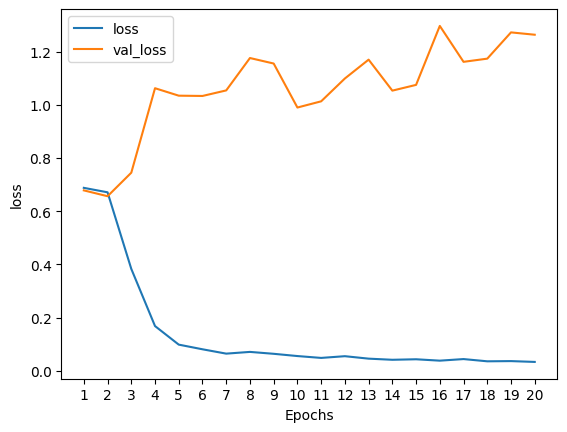

In [179]:
from sklearn.metrics import classification_report
testing_pred=np.round(model.predict(testing_padded))
print(classification_report(testing_labels, testing_pred))


plot_graphs(history, 'accuracy','lstm16_acc')
plot_graphs(history, 'loss','lstm16_loss')

convolutional NN

In [190]:
modelc = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [191]:
modelc.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, None, 16)          160000    
                                                                 
 conv1d_19 (Conv1D)          (None, None, 128)         10368     
                                                                 
 global_average_pooling1d_2  (None, 128)               0         
 3 (GlobalAveragePooling1D)                                      
                                                                 
 dense_68 (Dense)            (None, 64)                8256      
                                                                 
 dense_69 (Dense)            (None, 1)                 65        
                                                                 
Total params: 178689 (698.00 KB)
Trainable params: 178689 (698.00 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

In [192]:
modelc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [193]:
NUM_EPOCHS = 20
history = modelc.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(validation_padded, validation_labels), verbose=2)

Epoch 1/20
39/39 - 7s - loss: 0.6869 - accuracy: 0.5674 - val_loss: 0.6781 - val_accuracy: 0.5922 - 7s/epoch - 191ms/step
Epoch 2/20
39/39 - 4s - loss: 0.6823 - accuracy: 0.5674 - val_loss: 0.6754 - val_accuracy: 0.5922 - 4s/epoch - 107ms/step
Epoch 3/20
39/39 - 4s - loss: 0.6494 - accuracy: 0.5933 - val_loss: 0.6584 - val_accuracy: 0.6019 - 4s/epoch - 114ms/step
Epoch 4/20
39/39 - 3s - loss: 0.4887 - accuracy: 0.8174 - val_loss: 0.6706 - val_accuracy: 0.6084 - 3s/epoch - 65ms/step
Epoch 5/20
39/39 - 2s - loss: 0.2598 - accuracy: 0.9302 - val_loss: 0.7322 - val_accuracy: 0.6246 - 2s/epoch - 49ms/step
Epoch 6/20
39/39 - 1s - loss: 0.1461 - accuracy: 0.9602 - val_loss: 0.8301 - val_accuracy: 0.6278 - 1s/epoch - 36ms/step
Epoch 7/20
39/39 - 2s - loss: 0.1142 - accuracy: 0.9635 - val_loss: 0.9061 - val_accuracy: 0.6214 - 2s/epoch - 41ms/step
Epoch 8/20
39/39 - 1s - loss: 0.0886 - accuracy: 0.9732 - val_loss: 0.9405 - val_accuracy: 0.6440 - 728ms/epoch - 19ms/step
Epoch 9/20
39/39 - 1s - lo

13/13 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.60      0.61      0.60       179
           1       0.66      0.64      0.65       207

    accuracy                           0.63       386
   macro avg       0.63      0.63      0.63       386
weighted avg       0.63      0.63      0.63       386



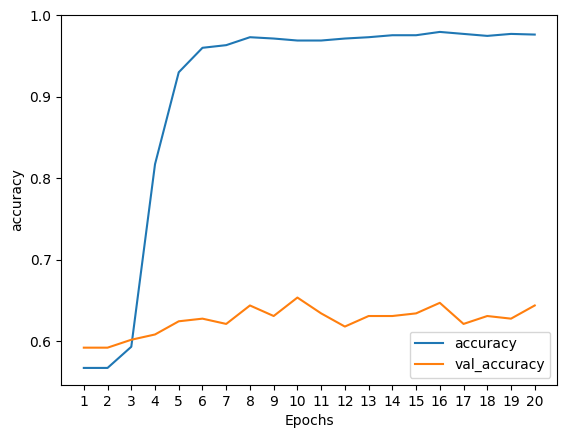

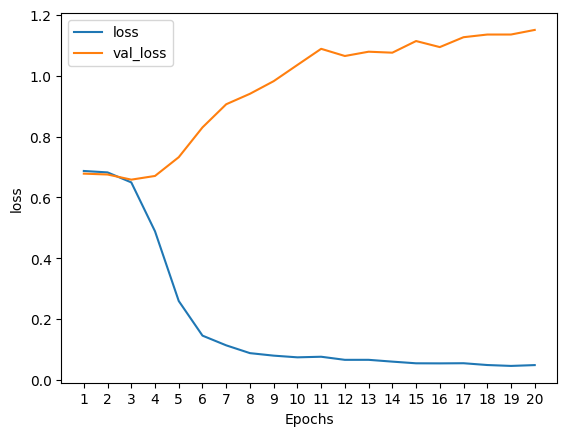

In [194]:
from sklearn.metrics import classification_report
testing_pred=np.round(modelc.predict(testing_padded))
print(classification_report(testing_labels, testing_pred))


plot_graphs(history, 'accuracy','conv16_acc')
plot_graphs(history, 'loss','conv16_loss')

sequential

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 64)           640000    
                                                                 
 global_average_pooling1d_2  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 24)                1560      
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 641585 (2.45 MB)
Trainable params: 641585 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
num_epochs = 20
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)

Epoch 1/20
39/39 - 10s - loss: 0.6882 - accuracy: 0.5633 - val_loss: 0.6801 - val_accuracy: 0.5922 - 10s/epoch - 253ms/step
Epoch 2/20
39/39 - 7s - loss: 0.6827 - accuracy: 0.5674 - val_loss: 0.6768 - val_accuracy: 0.5922 - 7s/epoch - 178ms/step
Epoch 3/20
39/39 - 5s - loss: 0.6794 - accuracy: 0.5674 - val_loss: 0.6755 - val_accuracy: 0.5922 - 5s/epoch - 140ms/step
Epoch 4/20
39/39 - 3s - loss: 0.6710 - accuracy: 0.5674 - val_loss: 0.6721 - val_accuracy: 0.5922 - 3s/epoch - 64ms/step
Epoch 5/20
39/39 - 3s - loss: 0.6519 - accuracy: 0.5755 - val_loss: 0.6661 - val_accuracy: 0.5922 - 3s/epoch - 75ms/step
Epoch 6/20
39/39 - 2s - loss: 0.6124 - accuracy: 0.6567 - val_loss: 0.6578 - val_accuracy: 0.5955 - 2s/epoch - 54ms/step
Epoch 7/20
39/39 - 2s - loss: 0.5449 - accuracy: 0.7752 - val_loss: 0.6466 - val_accuracy: 0.6149 - 2s/epoch - 54ms/step
Epoch 8/20
39/39 - 3s - loss: 0.4632 - accuracy: 0.8847 - val_loss: 0.6390 - val_accuracy: 0.5987 - 3s/epoch - 66ms/step
Epoch 9/20
39/39 - 1s - los

13/13 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.71      0.47      0.57       179
           1       0.65      0.84      0.73       207

    accuracy                           0.67       386
   macro avg       0.68      0.65      0.65       386
weighted avg       0.68      0.67      0.65       386



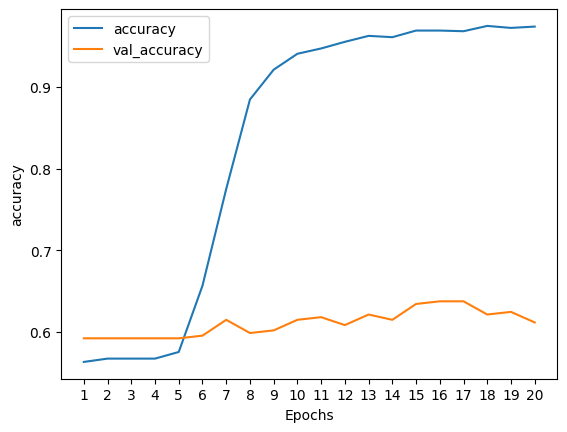

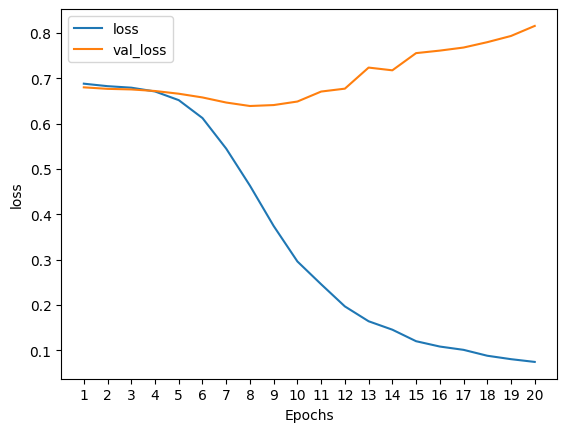

In [30]:
testing_pred=np.round(model.predict(testing_padded))
print(classification_report(testing_labels, testing_pred))

plot_graphs(history, "accuracy",'seq64_acc')
plot_graphs(history, "loss",'seq64_loss')

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

remov section 230 stand presid trump call representative🇺🇲🇺🇲🇺🇲🇺🇲🇺🇲bigtechelectioninterferencebigtechstandwithpresidenttrump 🇺🇲🇺🇲🇺🇲🇺🇲🇺🇲 ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
ban frack fact— kamala harri octob 8 2020aug 31 2020 – “i ban frack let say ban frack matter mani time donald trump lie me” –
1


In [ ]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))